# Time Series
<span style="font-size: 12px;">By: Marisol Hernandez</span>

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import numpy as np

## 1. What is a Time Series?
A **time series** is a sequence of observations at regular or irregular intervals over time. These observations can be collected over hours, days, months or even years, depending on the context and the nature of the phenomenon being analyzed.

In a time series, time is the independent variable, and the observations recorded over time are the dependent variables. The main objective of analyzing a time series is to understand the underlying patterns such as trends, seasonality, and cyclic behavior, in order to forecast future values.

<p align="center">
  <img src="imgs/time_series1.png" alt="Alt text" width="600" height="300">
</p>

Time series is a unique type of problem in machine learning where the time component plays a critical role in the model predictions. 

When analyzing a time series, it is important to keep in mind that the data are correlated over time. This means that observations at one point in time may depend on past observations and, in some cases, may also be affected by future observations.

### Applications
Here are some common applications of time series analysis:

1. **Economics and Finance**: Time series analysis is extensively used in economics and finance to understand and predict the behavior of financial markets. For instance, analyzing historical stock prices helps in forecasting future prices and making investment decisions. Economic indicators such as GDP, inflation rates, and unemployment rates are also studied over time to inform policy decisions and economic planning.

2. **Weather and Environmental Studies**: In meteorology and environmental science, time series data is crucial for weather forecasting and climate modeling. By analyzing past weather data, meteorologists can predict future weather conditions such as temperature, precipitation, and storm occurrences. Time series analysis also helps in understanding long-term climate change trends and their potential impacts on the environment.

3. **Transportation**: Time series analysis in transportation is used to monitor and predict traffic flow, public transport demand, and flight schedules. By analyzing historical traffic data, transportation planners can predict peak traffic times and optimize traffic light timings. Public transit systems can forecast passenger numbers to adjust service frequency, and airlines can predict and manage flight delays based on past performance and conditions.

## 2. Components of a Time Series Analysis
Let’s look at the various components of:

1. **Trend**: Represents the long-term movement or direction in the time series data. It shows the general pattern of increase or decrease over time, ignoring short-term fluctuations. For example, a steady rise in monthly sales over several years would indicate an upward trend. 

2. **Seasonality**: Refers to regular, repeating patterns or fluctuations in time series data that occur at specific intervals, such as daily, monthly, or yearly. These patterns are consistent and predictable, often influenced by seasonal factors like weather, holidays, or business cycles. An example is the increased retail sales during the holiday season each year.

3. **Cyclic Patterns**: Fluctuations in time series data that occur at irregular intervals, typically longer than one year. Unlike seasonality, cyclic patterns are not fixed or predictable and are often driven by economic or business cycles, such as periods of economic expansion and contraction. These patterns can vary in duration and intensity.

4. **Irregularity** (or Residual/Noise): Represents the random or unpredictable variations in time series data that cannot be attributed to trend, seasonality, or cyclic patterns. These variations are due to unforeseen events or random fluctuations and are typically short-term. Irregular components can be caused by factors like sudden market changes, natural disasters, or other random disturbances.

<p align="center">
  <img src="imgs/time_series2.png" alt="Alt text" width="600" height="300">
</p>

## 3. Steps in Time Series Analysis

### 3.1 Loading and exploring the data
Let's start by loading a dataset containing monthly airline passenger numbers. Note that the column `Month` is parsed as `datetime` object and set as the index of the DataFrame. 

In [42]:
# Load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
data

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [22]:
# Get descriptive statistics
data.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [23]:
# Get data types
data.dtypes

Passengers    int64
dtype: object

Let's also check for missing values,

In [24]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Passengers    0
dtype: int64


No missing values :) Let's still explore some ways to handle missing values if you ever come across them in your time series data.

#### Handling Missing Values in Time Series Data
Handling missing values in time series data is crucial for accurate analysis and forecasting. Here are some common strategies to deal with missing values:

1. **Imputation with Statistical Methods**:
    - **Mean/Median Imputation**: Replace missing values with the mean or median of the series. This method is simple but can distort the data's natural variability.

        ```python
        data.fillna(data.mean(), inplace=True)
        # or
        data.fillna(data.median(), inplace=True)
        ```

2. **Forward/Backward Fill**:
    - **Forward Fill**: Propagate the last observed value forward to fill missing values. Suitable for cases where the data is expected to remain relatively stable over short periods.

        ```python
        data.fillna(method='ffill', inplace=True)
        ```

    - **Backward Fill**: Use the next observed value to fill missing values. Useful when the future value is expected to be similar to the missing one.

        ```python
        data.fillna(method='bfill', inplace=True)
        ```

3. **Linear Interpolation**:
    - Interpolate missing values based on linear trends between observed data points. This method preserves the overall trend and can be more accurate than mean or median imputation.

        ```python
        data.interpolate(method='linear', inplace=True)
        ```

4. **Time-based Interpolation**:
    - Use time-specific methods like polynomial interpolation or spline interpolation to fill missing values. These methods consider the time dimension and can better capture complex trends and seasonality.

        ```python
        data.interpolate(method='time', inplace=True)
        ```

5. **Moving Average**:
    - Replace missing values with the moving average of neighboring data points. This smooths out short-term fluctuations and can provide a reasonable estimate.

        ```python
        data.fillna(data.rolling(window=3, min_periods=1).mean(), inplace=True)
        ```

### 3.2 Visualizing the Data
Visualizing the data helps to identify underlying patterns and trends.

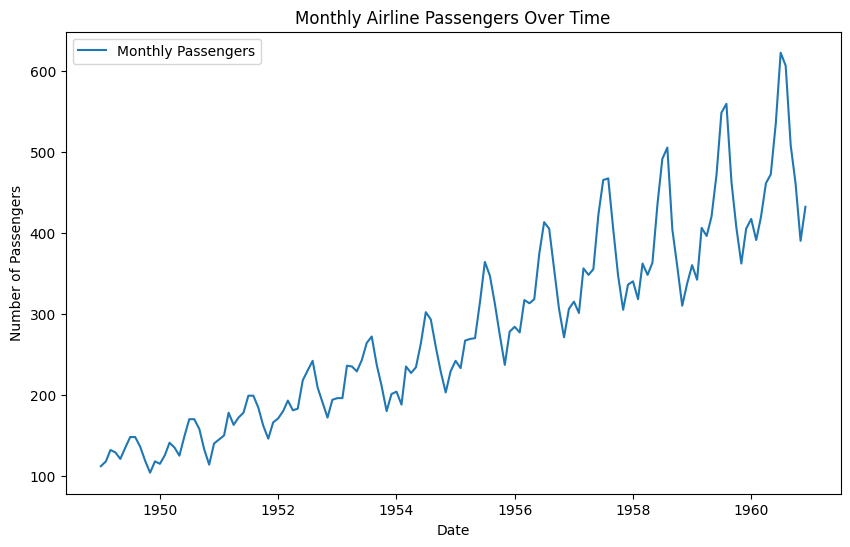

In [25]:
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(data, label='Monthly Passengers')
plt.title('Monthly Airline Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

As shown in the image, the visualization of the time series data depicts an upward trend with some repetitive patterns.

### 3.3 Decomposing the time series
Decomposing a time series allows us to break it down into its component parts: trend, seasonality, and residuals. This helps us understand the underlying structure of the time series data. We use the `seasonal_decompose` function of the `statsmodels` library to decompose the time series into its components.

In [26]:
# Decompose the time series
decomposition = seasonal_decompose(data, period = 12)

#### Trend analysis
A trend refers to the general direction in which the data is moving. To access its information, we resort to the `trend` component of the resulting `decomposition`.

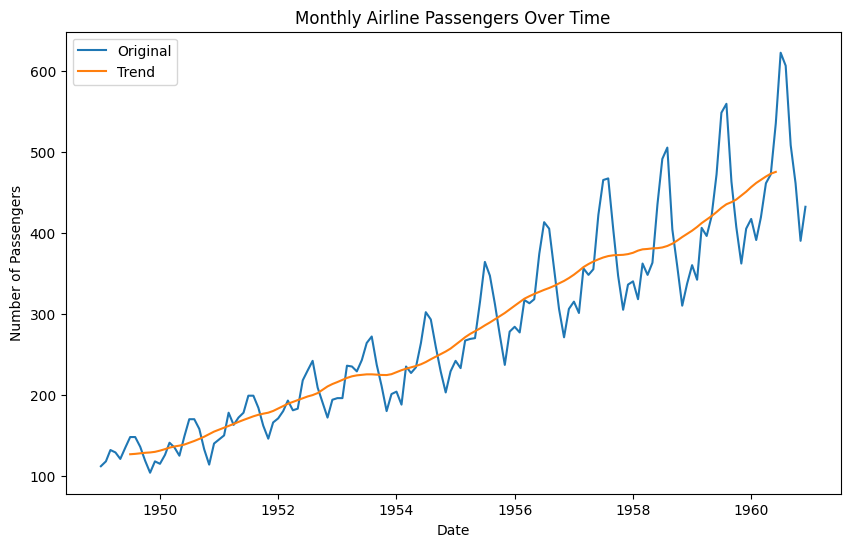

In [27]:
# Obtain the trend component
trend = decomposition.trend

# Plot the original time series data along with the trend
plt.figure(figsize=(10, 6))
plt.plot(data, label='Original')
plt.plot(trend, label='Trend')
plt.title('Monthly Airline Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

This confirms what can be observed from the original data: a clear positive trend over the years.

#### Seasonality analysis
Seasonality refers to repetitive patterns in the data. To access its information, we resort to the `seasonal` component of the resulting `decomposition`.

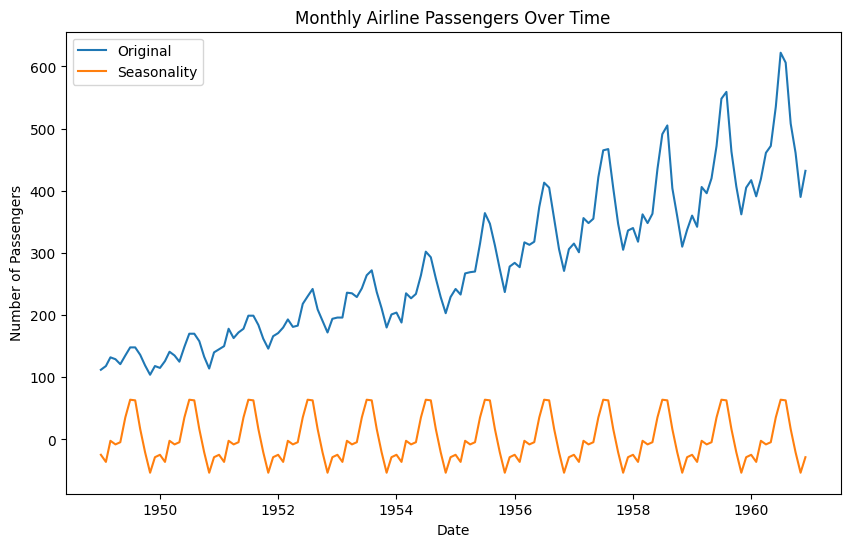

In [28]:
# Obtain the seasonal component
seasonal = decomposition.seasonal

# Plot the original time series data along with the seasonality
plt.figure(figsize=(10, 6))
plt.plot(data, label='Original')
plt.plot(seasonal, label='Seasonality')
plt.title('Monthly Airline Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

Now we can clealy see the repetitive nature in our time series.

#### Analysis of Variability
Variability involves the study of residuals: that is how the data fluctuate once trend and seasonality have been studied. To access their information, we resort to the `resid` component of the resulting `decomposition`.

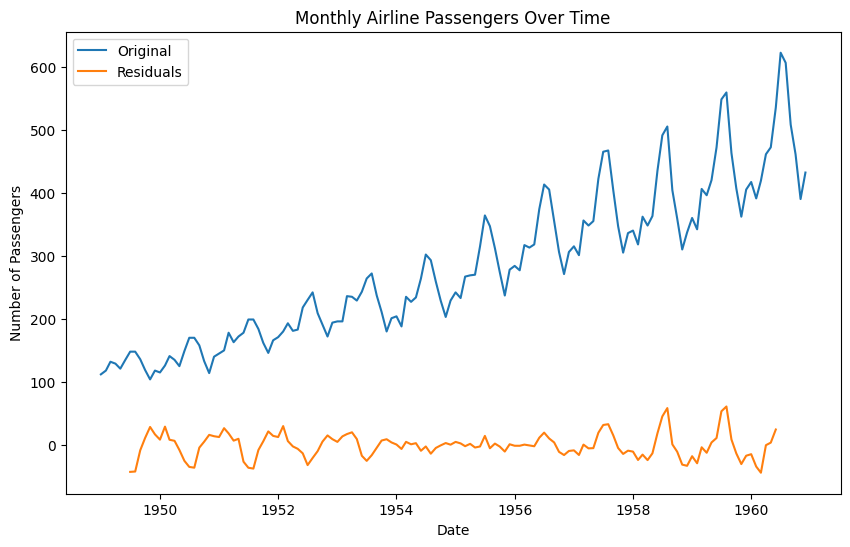

In [29]:
# Obtain the residual component
residual = decomposition.resid

# Plot the original time series data along with the trend
plt.figure(figsize=(10, 6))
plt.plot(data, label='Original')
plt.plot(residual, label='Residuals')
plt.title('Monthly Airline Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

This partly confirms what was observed, since the waste load is more noticeable at the beginning and end of the period studied.

#### Decomposing the Time Series In One Go

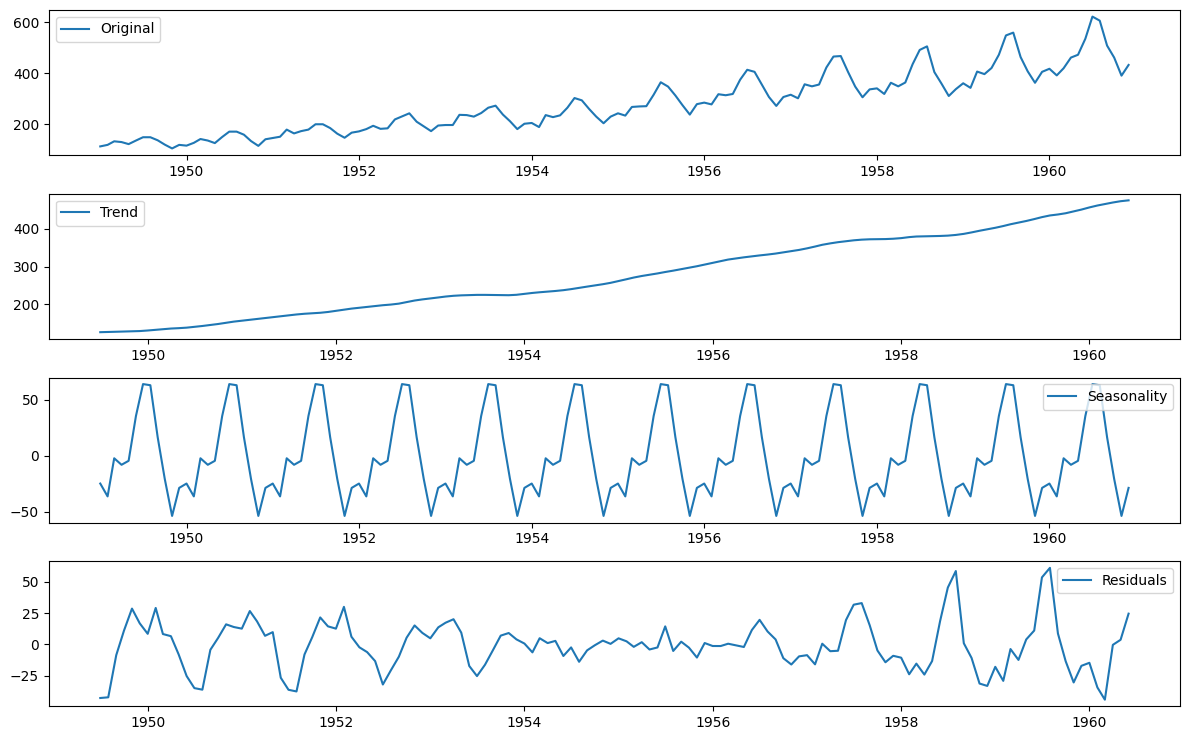

In [30]:
# Already decomposes the time series so this is commented out
# decomposition = seasonal_decompose(data, period = 12)
# trend = decomposition.trend
# seasonal = decomposition.seasonal
# residual = decomposition.resid

# Plot the decomposed components
plt.figure(figsize=(12, 7.5))

plt.subplot(411)
plt.plot(data, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

### 3.4 Checking for Stationarity
Time series data can be classified into stationary and non-stationary. Let's explore the difference between the two:

1. **Stationary**: Time series data is considered stationarity if statistical properties of the series, such as the mean, variance, and autocorrelation structure, do not change over time. Stationarity is an important property, as some models relies on the assumption that data is stationary. However, time series data often possesses the non-stationary property. Therefore, we need to understand how to identify non-stationary time series and how to transform it through various techniques, e.g. differencing.

2. **Non-stationary**: If either the mean-variance or covariance is changing with respect to time, the dataset is called non-stationary.

<p align="center">
  <img src="imgs/time_series3.png" alt="Alt text" width="800" height="350">
</p>

#### Methods to Check Stationarity
The most straightforward method would be examining the data visually. For example, the time series visualization above indicates that the time series follows an upward trend and its mean values increase over time, suggesting that the data is **non-stationary**. To quantify it stationarity, we can use the following method.

##### ADF (Augmented Dickey Fuller) test
The ADF (Augmented Dickey Fuller) test examines stationarity based on the null hypothesis that data is non-stationary and alternative hypothesis that data is stationary. If the p-value generated from the ADF test is less than or equal to 0.05, it provides stronger evidence to reject that data is non-stationary.

$$H_0= \text{The data is non-stationary}$$

$$H_A= \text{The data is stationary}$$

Interpreting the ADF Test:
- If the p-value is less than or equal to 0.05, we reject the null hypothesis and conclude that the time series is stationary.
- If the p-value is greater than 0.05, we fail to reject the null hypothesis and conclude that the time series is not stationary.

We can use `adfuller` from `statsmodels.tsa.stattools` module to perform the ADF test and generates the ADF value and p-value. In this example, p-value 0.99 is more than 0.05 thus this dataset is **non-stationary**.

In [31]:
# Perform the ADF test
result = adfuller(data)

print('ADF Statistic:', round(result[0], 2))
print('p-value:', round(result[1], 2))

ADF Statistic: 0.82
p-value: 0.99


#### Methods for Achieving Stationarity
If a time series is not stationary, you can apply transformations to achieve stationarity:

1. **Differencing**: Removes trends and seasonality by subtracting the previous observation from the current observation.

$$y_t= y_t ~–~y_{t-1}$$

In [32]:
# Apply differencing
data_diff = data.diff().dropna()

Let's plot the original and differenced data,

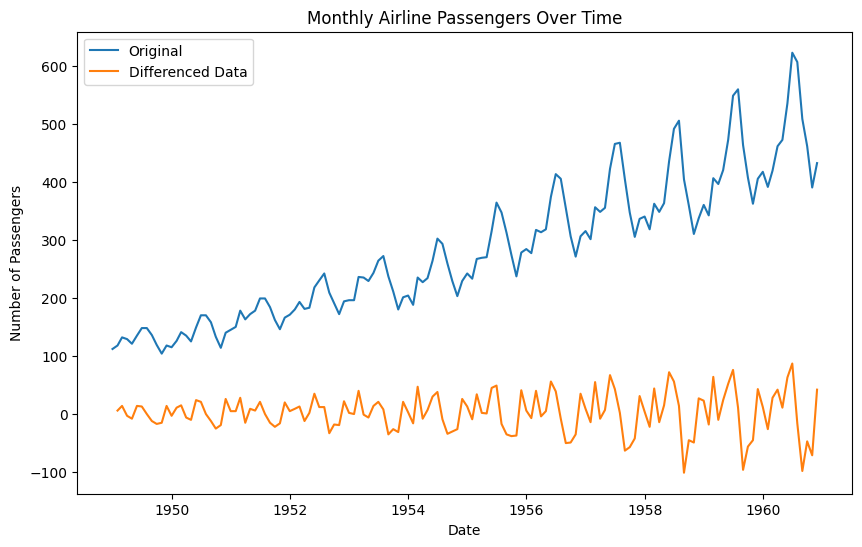

In [33]:
# Plot the original and differenced data
plt.figure(figsize=(10, 6))
plt.plot(data, label='Original')
plt.plot(data_diff, label='Differenced Data')
plt.title('Monthly Airline Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

We can see that the mean and variance is constant with time for the differenced data but lets perform the ADF test to check whether the differenced data is stationary,

In [34]:
# Perform the ADF test
result = adfuller(data_diff)

print('ADF Statistic:', round(result[0], 2))
print('p-value:', round(result[1], 2))

ADF Statistic: -2.83
p-value: 0.05


The p-value 0.05 is less than or equal to our signficance level, 0.05, thus this differenced dataset is **stationary**. 

Since differencing made our dataset stationary, we don't have to try any other methods but it's good to know that there are others you can try if differencing doesn't do the trick.

2. **Logarithmic Transformation**: Stabilizes the variance by applying a logarithmic transformation.

    ```python
        data_log = np.log(data)
    ```      

3. **Seasonal Differencing**: Removes seasonality by subtracting the value from the same period in the previous cycle.

    ```python
        data_seasonal_diff = data - data.shift(12)  # Example for monthly data with annual seasonality
    ```    

4. **Power Transformations**: Apply transformations like square root or Box-Cox to stabilize variance.

    ```python
        from sklearn.preprocessing import PowerTransformer

        pt = PowerTransformer()
        data_transformed = pt.fit_transform(data)
    ```   

### 3.5 Applying Statistical Models for Forecasting
One of the common models for time series forecasting is ARIMA (AutoRegressive Integrated Moving Average). Let's apply ARIMA to forecast future values.

#### Understanding ARIMA
ARIMA models are defined by three parameters:

- `p`: The number of lag observations included in the model (autoregressive part).

- `d`: The number of times that the raw observations are differenced (integrated part).

- `q`: The size of the moving average window (moving average part).

#### Finding the Optimal Parameters
We'll use `auto_arima` to find the best parameters for our ARIMA model.

In [35]:
# Fit auto_arima to find the best p, d, q
model = auto_arima(data_diff, seasonal = True, trace = True, m = 12)

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1033.479, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1022.316, Time=0.20 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1022.905, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1031.508, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1022.343, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1021.137, Time=0.57 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.22 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1022.411, Time=0.36 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1034.068, Time=0.39 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1023.008, Time=0.70 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1022.906, Time=1.84 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1021.017, Time=0.64 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1022.315, Time=0.14 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=1.57 sec
 ARIMA(0,0

As we can see, the function searches the possible solution space to estimate the best parameters. In this case, we would have an $\text{ARIMA}(0,0,1)$. The model returned by this function is fully usable, like any other we have seen, and its summary() function returns statistical and performance information that is of great value:

In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  143
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Mon, 22 Jul 2024   AIC                           1019.179
Time:                                     21:53:52   BIC                           1030.680
Sample:                                 02-01-1949   HQIC                          1023.852
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.371      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Forecasting Future Values
Once the model has been trained, it can be used to predict into the future (we will predict the next 12 months).

In [37]:
forecast = model.predict(12)
forecast

1961-01-01    19.346932
1961-02-01   -24.244912
1961-03-01    36.280007
1961-04-01    36.323602
1961-05-01    14.329657
1961-06-01    57.816446
1961-07-01    89.458676
1961-08-01   -13.228999
1961-09-01   -96.797005
1961-10-01   -50.216336
1961-11-01   -67.015466
1961-12-01    45.180750
Freq: MS, dtype: float64

As you can see, the forecasted data is differenced. Let's plot it with our differenced data,

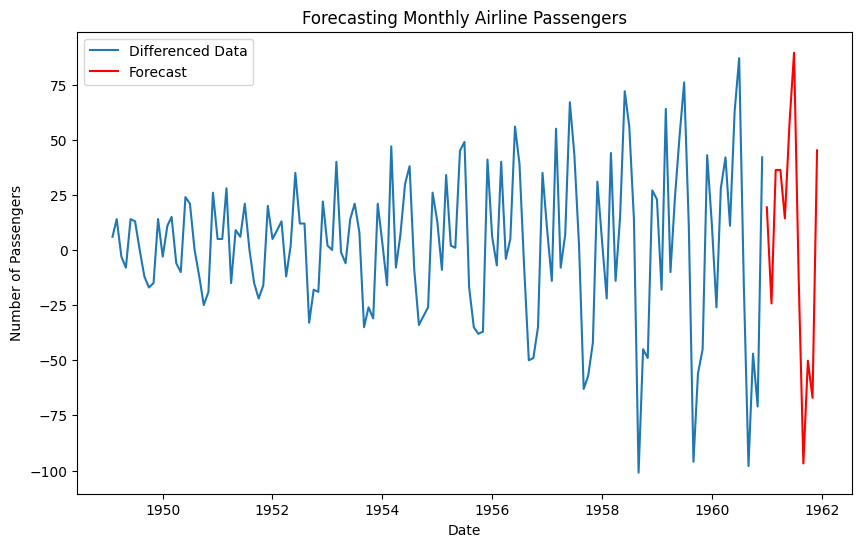

In [40]:
# Forecast the next 12 months
forecast_index = pd.date_range(start=data.index[-1], periods=13, freq='MS')[1:]

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(data_diff, label='Differenced Data')
plt.plot(forecast_df, label='Forecast', color='red')
plt.title('Forecasting Monthly Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

Now lets convert the forecasted differenced data back to the original scale by cumulatively summing the forecast values and adding the last observed value from the original time series. This will reverse the differencing operation.

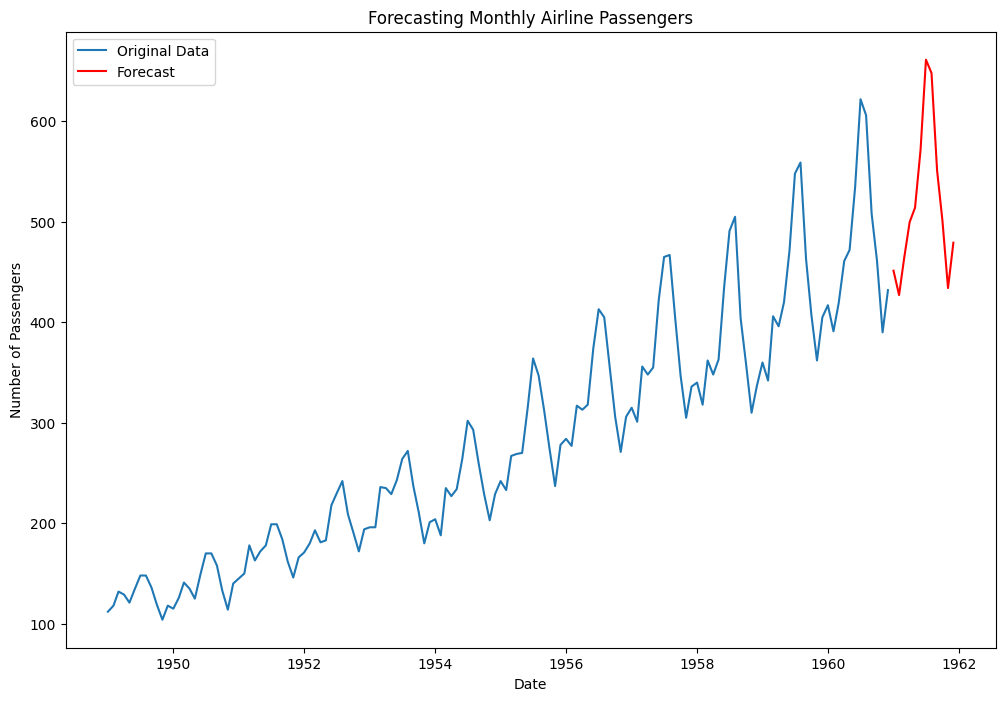

In [39]:
# Convert the forecasted differenced data back to the original scale
# Cumulative sum of the forecasted differenced data
forecast_cumsum = np.cumsum(forecast)

# Add the last observed value from the original data
last_observed_value = data['Passengers'].iloc[-1]
forecast_original_scale = last_observed_value + forecast_cumsum

# Create a DataFrame for the forecast on the original scale
forecast_df = pd.DataFrame(forecast_original_scale, index=forecast_index, columns=['Forecast'])

# Plot the original data and forecast
plt.figure(figsize=(12, 8))

# Plot the original data
plt.plot(data, label='Original Data')

# Plot the forecasted data
plt.plot(forecast_df, label='Forecast', color='red')

plt.title('Forecasting Monthly Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()
